# A simple GAN to generate samples from Gaussian distribution (WGAN-GP)
References:
1. https://github.com/togheppi/vanilla_GAN
2. https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb
3. https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
4. https://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
5. https://github.com/kremerj/gan
6. https://github.com/igul222/improved_wgan_training
7. https://github.com/AYLIEN/gan-intro/blob/master/gan.py
8. https://github.com/kremerj/gan/blob/master/gan.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable

## Understand target distribution: Gaussian distribution

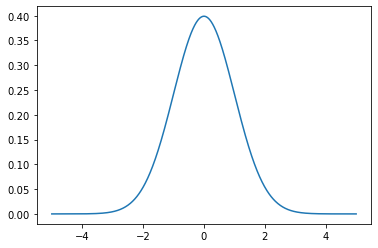

In [2]:
mu,sigma = 0,1
num_samples = 1000
xs = np.linspace(-5, 5, num_samples) # interval = 10/1000=0.01
samples = norm.pdf(xs, mu, sigma)
plt.plot(xs, samples)

## Classes for data sampling

In [3]:
# Real data distribution
class RealDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, num_samples):
        samples = np.random.normal(self.mu, self.sigma, num_samples)
        samples.sort()
        
        return samples

# Noise data distribution as inputs for the generator
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.random(num_samples)*0.01 # Random floats with uniform dist. in the interval [0.0, 0.01)
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset
        
        return samples

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()

        # Fully-connected layer
        fc = nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        nn.init.normal_(fc.weight)
        nn.init.constant_(fc.bias, 0.0)
        # Hidden layer
        self.hidden_layer = nn.Sequential(fc, nn.ReLU())
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0.0)

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        
        return out

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()

        # Fully-connected layer
        fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        nn.init.normal_(fc1.weight)
        nn.init.constant_(fc1.bias, 0.0)
        # Hidden layer
        self.hidden_layer = nn.Sequential(fc1, nn.ReLU())
        # Fully-connected layer
        fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(fc2.weight)
        nn.init.constant_(fc2.bias, 0.0)
        # Output layer
        self.output_layer = nn.Sequential(fc2, nn.Sigmoid())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        
        return out

## TestSample class

In [6]:
# Test samples
class TestSample:
    def __init__(self, discriminator, generator, realD, data_range, batch_size, num_samples, num_bins):
        self.D = discriminator
        self.G = generator
        self.realD = realD
        self.bs = batch_size
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.xs = np.linspace(-data_range, data_range, num_samples)
        self.bins = np.linspace(-data_range, data_range, num_bins)

    def decision_boundary(self):
        db = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            x_ = self.xs[self.bs*i:self.bs*(i+1)]
            x_ = Variable(torch.FloatTensor(np.reshape(x_, [self.bs, 1])))

            db[self.bs*i:self.bs*(i+1)] = self.D(x_).detach().numpy()

        return db

    def real_distribution(self):
        d = self.realD.sample(self.num_samples)
        p_data, _ = np.histogram(d, self.bins, density=True)
        
        return p_data

    def gen_distribution(self):
        zs = self.xs
        g = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            z_ = zs[self.bs*i:self.bs*(i+1)]
            z_ = Variable(torch.FloatTensor(np.reshape(z_, [self.bs, 1])))
            g[self.bs*i:self.bs*(i+1)] = self.G(z_).detach().numpy()

        p_gen, _ = np.histogram(g, self.bins, density=True)
        
        return p_gen

## Display class 

In [7]:
class Display:
    def __init__(self, num_samples, num_bins, data_range, mu, sigma):
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.data_range = data_range
        self.mu = mu
        self.sigma = sigma
    
    def plot_result(self, db_trained, p_data, p_gen, epoch):
        d_x = np.linspace(-self.data_range, self.data_range, len(db_trained))
        p_x = np.linspace(-self.data_range, self.data_range, len(p_data))

        f, ax = plt.subplots(1)
        ax.plot(d_x, db_trained, label='Decision boundary')
        ax.set_ylim(0, max(1, np.max(p_data)*1.1))
        ax.set_xlim(max(self.mu-self.sigma*5, -self.data_range*0.9), 
                    min(self.mu+self.sigma*5, self.data_range*0.9))
        plt.plot(p_x, p_data, label='Real data')
        plt.plot(p_x, p_gen, label='Generated data')
        plt.title('Gaussian Approximation using GAN: ' + '(mu: %3g,' % self.mu + ' sigma: %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend(loc=1)
        plt.grid(True)

        # Save plot
        save_dir = "result/"
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        plt.savefig(save_dir + 'Gaussian' + '_mu_%g' % self.mu +
                    '_sigma_%g' % self.sigma + '_ep_%g' % epoch + '.png')

        plt.show()

    def plot_result_pre(self, db_pre_trained, db_trained, p_data, p_gen):
        d_x = np.linspace(-self.data_range, self.data_range, len(db_trained))
        p_x = np.linspace(-self.data_range, self.data_range, len(p_data))

        f, ax = plt.subplots(1)
        ax.plot(d_x, db_pre_trained, '--', label='Decision boundary (pre-trained)')
        ax.plot(d_x, db_trained, label='Decision boundary')
        ax.set_ylim(0, max(1, np.max(p_data)*1.1))
        ax.set_xlim(max(self.mu-self.sigma*5, -self.data_range*0.9), 
                    min(self.mu+self.sigma*5, self.data_range*0.9))
        plt.plot(p_x, p_data, label='Real data')
        plt.plot(p_x, p_gen, label='Generated data')
        plt.title('Gaussian Approximation using GAN: ' + '(mu: %3g,' % self.mu + ' sigma: %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend(loc=1)
        plt.grid(True)

        # Save plot
        #save_dir = "result/"
        #if not os.path.exists(save_dir):
        #    os.mkdir(save_dir)
        #plt.savefig(save_dir + 'Gaussian' + '_mu_%g' % self.mu + '_sigma_%g' % self.sigma + '.png')

        plt.show()

## Pretrain discriminator

In [8]:
# Hyper-parameters
mu = 0.0
sigma = 1.0
data_range = 5
batch_size = 10

input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 200
num_epochs_pre = 2000
learning_rate = 0.005
lambda_reg=0.1

0 0.0652373880147934
100 0.010492353700101376
200 0.00851980596780777
300 0.012980352155864239
400 0.010434228926897049
500 0.012732799164950848
600 0.008959089405834675
700 0.007352044805884361
800 0.008984408341348171
900 0.013709256425499916
1000 0.008963615633547306
1100 0.00865302886813879
1200 0.008173239417374134
1300 0.010622814297676086
1400 0.008313113823533058
1500 0.007804661989212036
1600 0.009681209921836853
1700 0.011565963737666607
1800 0.011496168561279774
1900 0.011136304587125778


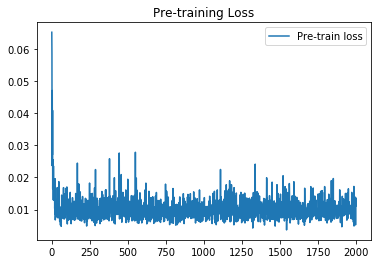

In [9]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim)

# Loss function (WGAN loss)
#pre_criterion = torch.nn.BCELoss()
pre_criterion = torch.nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

num_samples_pre = 1000
num_bins_pre = 100 # number of equal-width bins in a histogram
D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    real = realData.sample(num_samples_pre)
    histc, edges = np.histogram(real, num_bins_pre, density=True)

    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)  # normalize y_ to range [0,1]
    #print('len of y_: ', len(y_), ', y_: ', y_)
    x_ = edges[1:]

    x_ = Variable(torch.FloatTensor(np.reshape(x_, [num_bins_pre, input_dim])))
    y_ = Variable(torch.FloatTensor(np.reshape(y_, [num_bins_pre, output_dim])))

    # Train D model
    optimizer.zero_grad()
    D_pre_decision = D(x_)
    D_pre_loss = pre_criterion(D_pre_decision, y_)
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(epoch, D_pre_loss.item())

# Plot loss
fig, ax = plt.subplots()
losses = np.array(D_pre_losses)
plt.plot(losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend()
plt.show()

In [10]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Test sample after pre-training (to be drawn later)
num_samples = 10000
num_bins = 50
sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
db_pre_trained = sample.decision_boundary()

## Train GAN

epoch:0, D loss:-0.4845333993434906, G loss:-0.01593407429754734


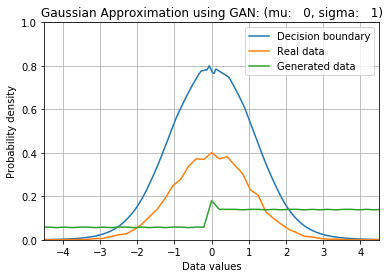

epoch:10, D loss:-0.581787645816803, G loss:-0.1878487765789032


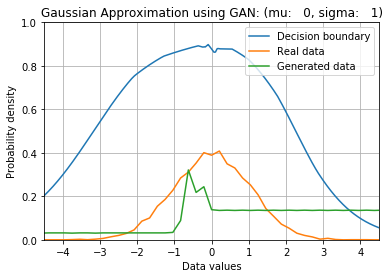

epoch:20, D loss:-0.25972992181777954, G loss:-0.5106918811798096


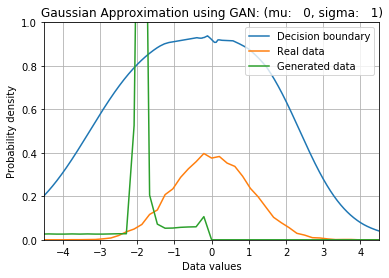

epoch:30, D loss:-0.3384115695953369, G loss:-0.4998709261417389


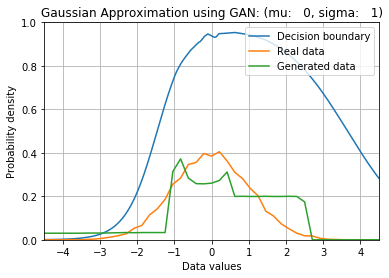

epoch:40, D loss:-0.18795785307884216, G loss:-0.492030531167984


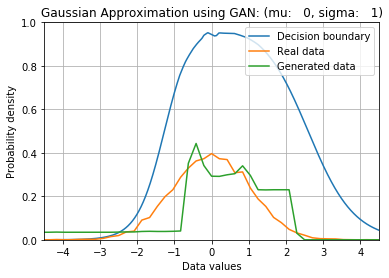

epoch:50, D loss:-0.08198786526918411, G loss:-0.5580689311027527


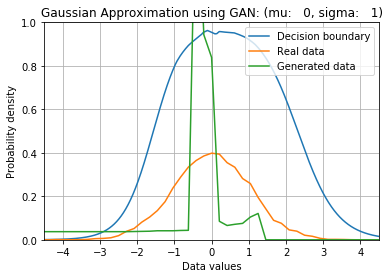

epoch:60, D loss:-0.24595558643341064, G loss:-0.6141790151596069


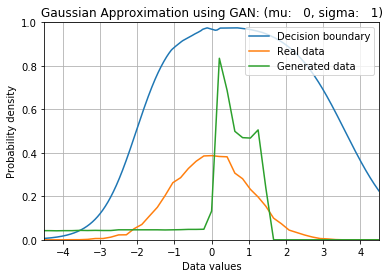

epoch:70, D loss:-0.1287020444869995, G loss:-0.7517116069793701


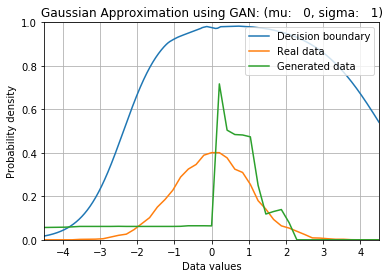

epoch:80, D loss:0.12406694144010544, G loss:-0.9614123106002808


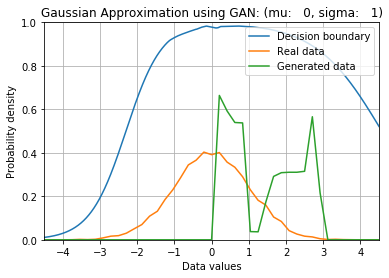

epoch:90, D loss:0.018291905522346497, G loss:-0.8158210515975952


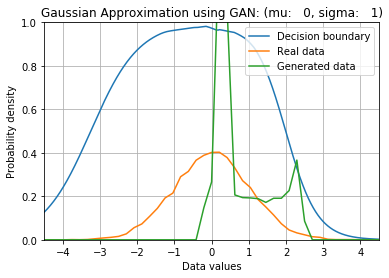

epoch:100, D loss:0.1612968146800995, G loss:-0.8068326115608215


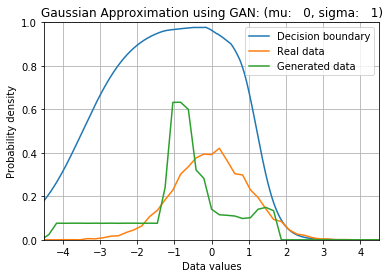

epoch:110, D loss:0.12232479453086853, G loss:-0.7580050230026245


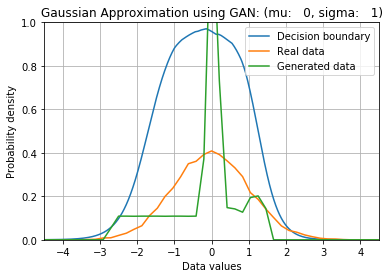

epoch:120, D loss:0.14536818861961365, G loss:-0.8726121783256531


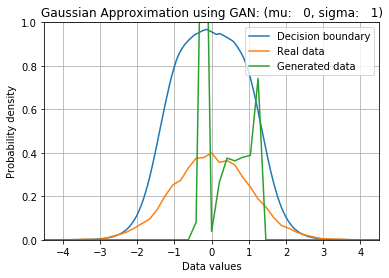

epoch:130, D loss:0.20359531044960022, G loss:-0.9431977272033691


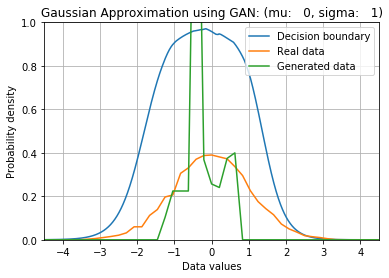

epoch:140, D loss:0.14553873240947723, G loss:-0.9695627093315125


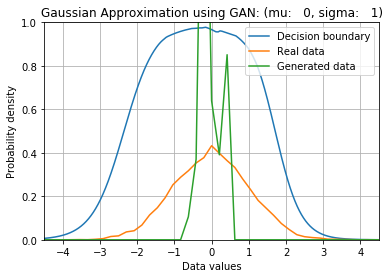

epoch:150, D loss:0.134012833237648, G loss:-0.9799882769584656


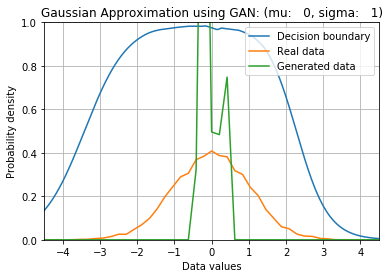

epoch:160, D loss:0.0976199060678482, G loss:-0.9848967790603638


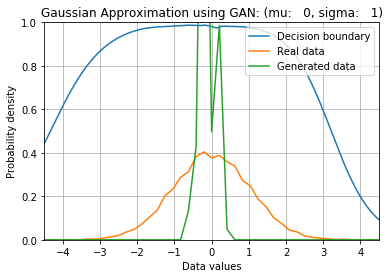

epoch:170, D loss:0.09516638517379761, G loss:-0.9868950843811035


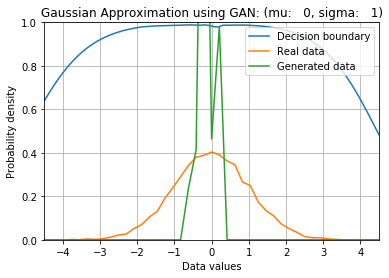

epoch:180, D loss:0.09628347307443619, G loss:-0.9872944951057434


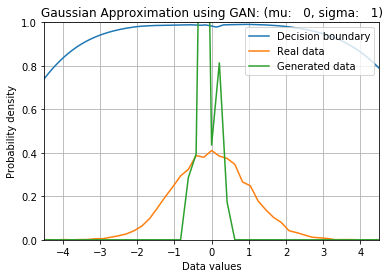

epoch:190, D loss:0.09530822187662125, G loss:-0.9868394732475281


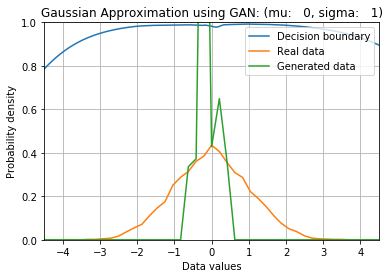

In [11]:
# Optimizers
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

D_losses = []
G_losses = []
for epoch in range(num_epochs):
    # Generate samples
    x_ = realData.sample(batch_size)
    x_ = Variable(torch.FloatTensor(np.reshape(x_, [batch_size, input_dim])))
    y_real_ = Variable(torch.ones([batch_size, output_dim]))
    y_fake_ = Variable(torch.zeros([batch_size, output_dim]))

    # Train discriminator with real data
    D_real_decision = D(x_)
    D_real_loss = torch.mean(D_real_decision)

    # Train discriminator with fake data
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    D_fake_loss = torch.mean(D_fake_decision)
    
    # Create the gradient penalty operations
    epsilon = torch.rand(batch_size, 1)     # uniform random number in [0,1)
    interpolation = epsilon * x_ + (1 - epsilon) * z_
    gradients = torch.autograd.grad(outputs=D(interpolation),
                                    inputs=interpolation,
                                    grad_outputs=torch.ones(D(interpolation).size()),
                                    create_graph=True,
                                    retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    penalty = ((torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12) - 1) ** 2.0).mean()

    # Back propagation
    D_loss = D_fake_loss - D_real_loss + lambda_reg * penalty
    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train generator
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    G_loss = -torch.mean(D_fake_decision)

    # Back propagation
    D.zero_grad()
    G.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    # Save loss values for plot
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
    
    if epoch % 10 == 0:
        print('epoch:{}, D loss:{}, G loss:{}'.format(epoch, D_loss.item(), G_loss.item()))
        # Test sample after GAN-training
        sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
        db_trained = sample.decision_boundary()
        p_data = sample.real_distribution()
        p_gen = sample.gen_distribution()

        # Display result
        display = Display(num_samples, num_bins, data_range, mu, sigma)
        display.plot_result(db_trained, p_data, p_gen, epoch)

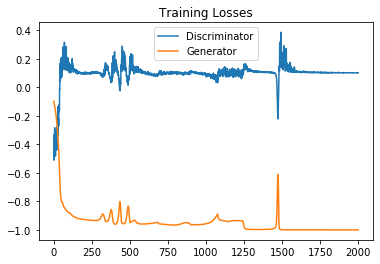

In [12]:
# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()